In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import spacy
from tqdm import tqdm

# Reading the data

In [2]:
df=pd.read_csv("train.csv")
print("No of data points: ",df.shape[0])

No of data points:  404290


In [3]:
# printing the first five rows of dataframe
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
#checking whether there is null value in data also chacking its types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

1. id: Looks like a simple rowID
2. qid{1, 2}: The unique ID of each question in the pair
3. question{1, 2}: The actual textual contents of the questions.
4. is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

## Distribution of data points among output classes
   No of duplicates(similar) or non-duplicates(non-similar) questions

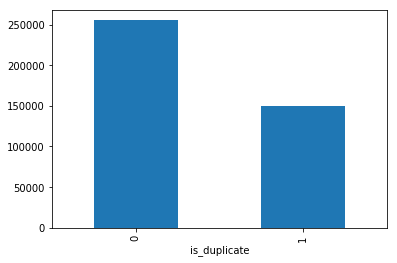

In [6]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [7]:
print("Total number of question pair: ",len(df))

Total number of question pair:  404290


In [8]:
print("Data contains {}% of similar(duplicate) questions".format(round(((df.is_duplicate.mean()*100)),2)))
print("Data contains {}% of non-similar(non-duplicate) questions".format(round(100-((df.is_duplicate.mean()*100)),2)))

Data contains 36.92% of similar(duplicate) questions
Data contains 63.08% of non-similar(non-duplicate) questions


## No of unique question

In [9]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs=len(np.unique(qids))
ques_more_than_one=np.sum(qids.value_counts()>1)
print("Total no of unique questions in are: {}".format(unique_qs))
print("No of unique questions that appered more than once are {} and their percentage is {}%".format(ques_more_than_one,round(((ques_more_than_one/unique_qs)*100),2)))
print("Maximum number of times a question is repeated is: {}".format(qids.value_counts().max()))

Total no of unique questions in are: 537933
No of unique questions that appered more than once are 111780 and their percentage is 20.78%
Maximum number of times a question is repeated is: 157


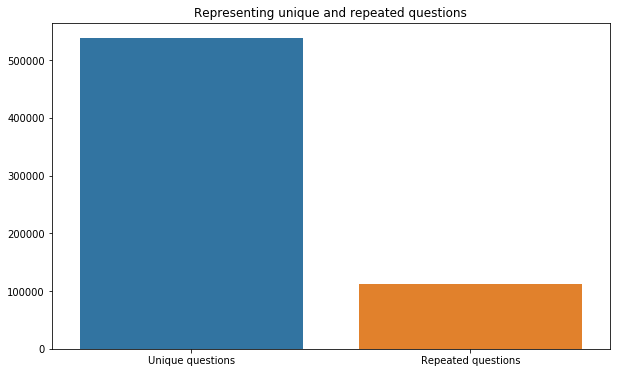

In [10]:
x=["Unique questions","Repeated questions"]
y=[unique_qs,ques_more_than_one]
plt.figure(figsize=(10,6))

plt.title("Representing unique and repeated questions")
sns.barplot(x,y)
plt.show()

## checking for duplicate pairs

In [11]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


## Number of occurrences of each question

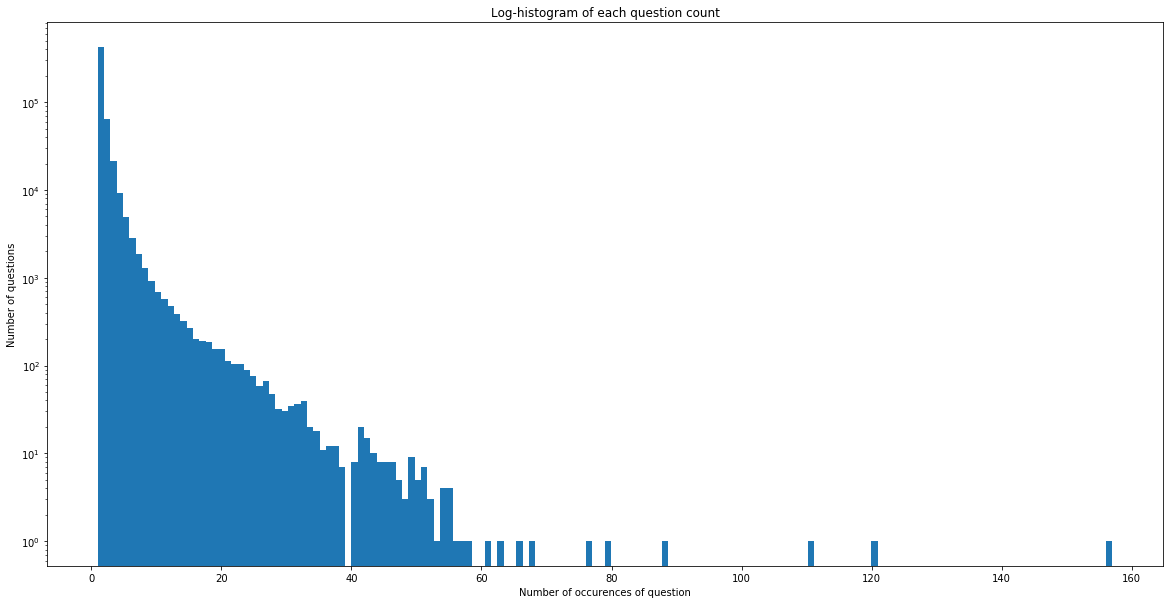

In [12]:
plt.figure(figsize=(20, 10))
plt.title("Log-histogram of each question count")
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.yscale('log',nonposy='clip')
plt.hist(qids.value_counts(),bins=160)
plt.show()

## checking for Null values

In [13]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [14]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# Basic Feature Extraction (before cleaning)

Let us now construct a few features like:

1. freq_qid1 = Frequency of qid1's
2. freq_qid2 = Frequency of qid2's
3. q1len = Length of q1
4. q2len = Length of q2
5. q1_n_words = Number of words in Question 1
6. q2_n_words = Number of words in Question 2
7. word_Common = (Number of common unique words in Question 1 and Question 2)
8. word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
9. word_share = (word_common)/(word_Total)
10. freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
11. freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [15]:
# Creating the above mention features
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        # Fetching number of common words in question 1 and question 2
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        # Fetching total number of words in question1 and question 2
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        # It is ratio of common words in both question by total words in both questions
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


##  Analysis of some of the extracted features

1. Here are some questions have only one single words.

In [16]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


## Preprocessing the text
1. Removing HTML tags
2. Removing Punctuations
3. Performing stemming
4. Removing Stopwords
5. Expanding contractions etc.

In [17]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [18]:
def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)
    return df

In [19]:
#cleaning the text and merging with previous text

print("Extracting features for train:")
df = pd.read_csv("df_fe_without_preprocessing_train.csv")
data = extract_features(df)
data.to_csv("df_fe_without_preprocessing_train.csv", index=False)
df.head()

Extracting features for train:


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


## Analysis of extracted features

### Plotting a word cloud

1. Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
2. We can observe the most frequent occuring words

In [47]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]
# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [48]:
#Splitting the questions in words and collecting all at one place
def split(data):
    document=[]
    for sentence in data:
        text=""
        for i in range(len(sentence)):
            if(sentence[i]!=" "):
                text+=sentence[i]
            elif(sentence[i]==" " and text==""):
                continue
            else:
                document.append(text)
                text=""
    return document

In [49]:
textp_w=split(p)
textn_w=split(n)

# creating set of stopwords
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
stopwords.remove("like")

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 2977366
Total number of words in non duplicate pair questions : 6123061


### Creating word cloud for duplicate question pair

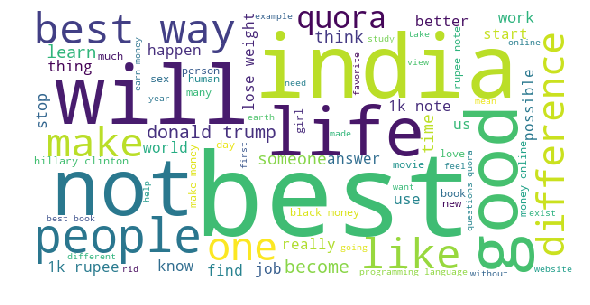

In [37]:
comment_words = ' '
data=p[0:10000]
# iterate through the csv file 
for val in data: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud=WordCloud(height=300,width=600,background_color='white',stopwords=stopwords,min_font_size=10,max_words=len(data)).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize=(8,8),facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


### Creating word cloud for non-duplicate question pair

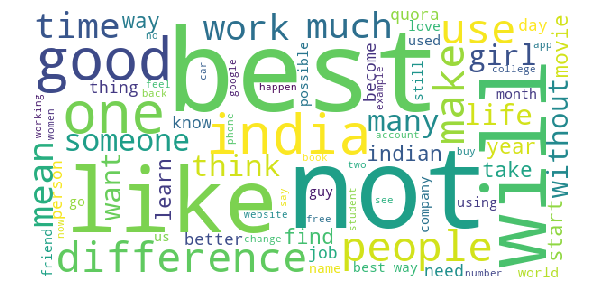

In [38]:
comment_words = ' '
data=n[0:10000]
# iterate through the csv file 
for val in data: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud=WordCloud(height=300,width=600,background_color='white',stopwords=stopwords,min_font_size=10,max_words=len(data)).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize=(8,8),facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


#### Pair plot of features q1_n_words, q2_n_words,word_Common,word_Total,word_share

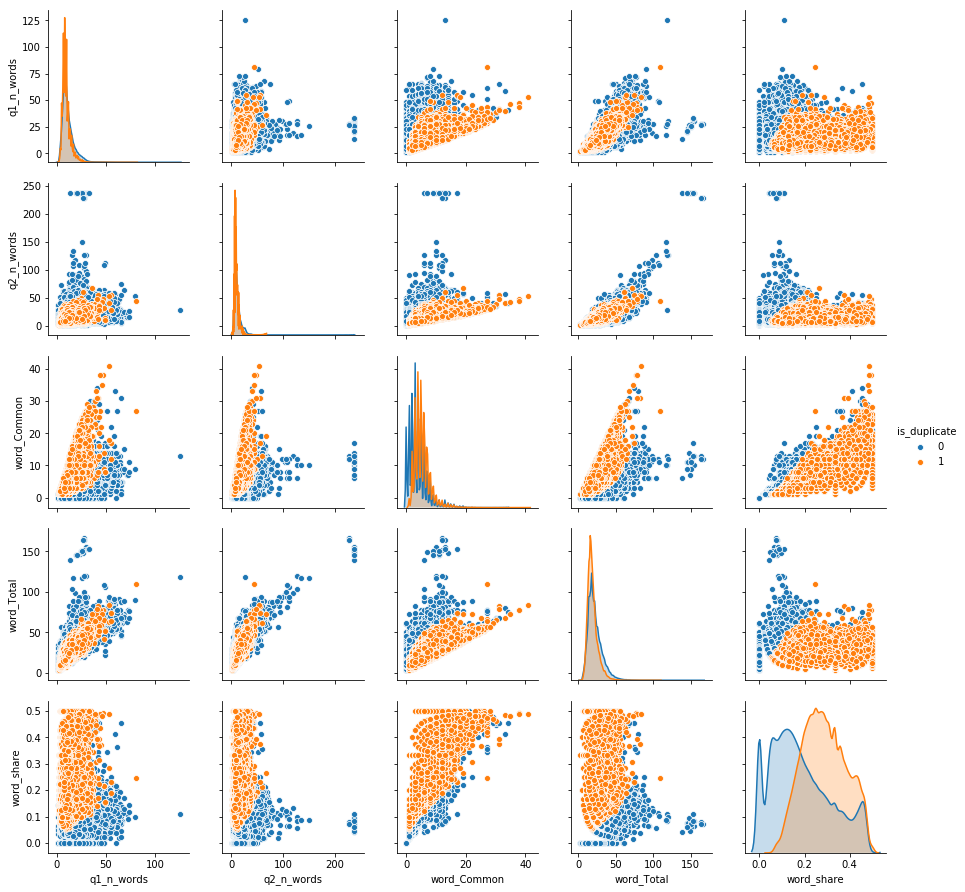

In [43]:
n = df.shape[0]
sns.pairplot(df[['q1_n_words', 'q2_n_words','word_Common', 'word_Total', 'word_share', 'is_duplicate']][0:n], hue='is_duplicate', vars=['q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share'])
plt.show()

## Featurizing text with tfidf weighted word-vectors

In [54]:
dfppro=pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df1=dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro[['id','question1','question2']]
duplicate = dfppro.is_duplicate

In [74]:
df2=df2.fillna(' ')
#assigning new dataframe with columns question(q1+q2) and id same as df2
new_df=pd.DataFrame()
new_df['questions'] = df2.question1 + ' ' + df2.question2
new_df['id']=df2.id
new_df.head()
X=new_df.merge(df1,on='id',how='left')# merging new_df with df1

In [78]:
X=X.drop('id',axis=1)
X.columns

Index(['questions', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       'freq_q1-q2'],
      dtype='object')

In [85]:
Y=np.array(duplicate)

In [87]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=3,test_size=0.3)

In [88]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(283003, 12)
(283003,)
(121287, 12)
(121287,)


In [89]:
#seperating questions for tfidf vectorizer
X_train_ques=X_train['questions']
X_test_ques=X_test['questions']

X_train=X_train.drop('questions',axis=1)
X_test=X_test.drop('questions',axis=1)

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
# list_of_sentance_train=[]
# for sentance in X_train_ques:
#     list_of_sentance_train.append(sentance.split())

tfidf = TfidfVectorizer(lowercase=False )
tfidf.fit_transform(X_train_ques)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

1. After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores
2. here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
3. It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [96]:
#for train dataset
import en_core_web_sm
nlp = en_core_web_sm.load()

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train_ques)):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
#df['q1_feats_m'] = list(vecs1)

100%|████████████████████████████████████████████████████████████████████████| 283003/283003 [1:04:53<00:00, 72.69it/s]


In [97]:
vecs2 = []
for qu2 in tqdm(list(X_test_ques)):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
#df['q2_feats_m'] = list(vecs2)

100%|██████████████████████████████████████████████████████████████████████████| 121287/121287 [27:36<00:00, 73.21it/s]


In [98]:
first_df=pd.DataFrame(vecs1)
sec_df=pd.DataFrame(vecs2)

In [102]:
from scipy.sparse import hstack
X_train = hstack((X_train.values,first_df))
X_test= hstack((X_test.values,sec_df))
print(X_train.shape)
print(X_test.shape)


(283003, 107)
(121287, 107)


# Machine Learning Models

In [113]:
from collections import Counter
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss

In [103]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 107)
Number of data points in test data : (121287, 107)


In [107]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
print(train_distr)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Counter({0: 178194, 1: 104809})
Class 0:  0.6296541026066862 Class 1:  0.37034589739331386
---------- Distribution of output variable in train data ----------
Class 0:  0.3665190828365777 Class 1:  0.3665190828365777


In [108]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Linear SVM with hyperparameter tuning

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 10

For values of alpha =  1e-05 The log loss is: 0.5070703064194723


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 10

For values of alpha =  0.0001 The log loss is: 0.46855752260227373


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 10

For values of alpha =  0.001 The log loss is: 0.4699151940758299


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 10

For values of alpha =  0.01 The log loss is: 0.5323727125522927


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 10

For values of alpha =  0.1 The log loss is: 0.5879829698168856


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 10

For values of alpha =  1 The log loss is: 0.6447118909754164


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 10

For values of alpha =  10 The log loss is: 0.6467519724934112


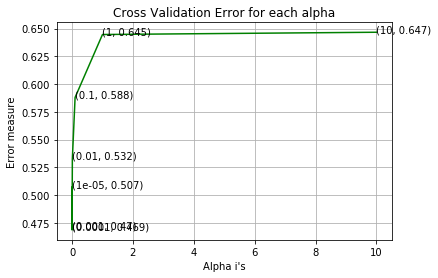

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 10

For values of best alpha =  0.0001 The train log loss is: 0.4707729021060151
For values of best alpha =  0.0001 The test log loss is: 0.46855752260227373
Total number of data points : 121287


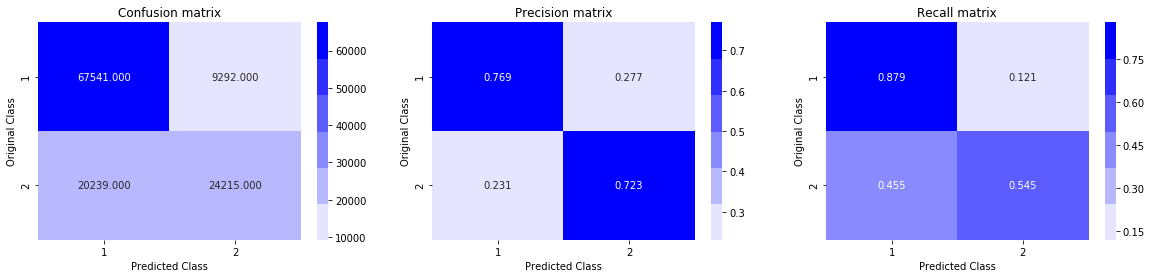

In [116]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)),(alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

est_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)